# Genre and Drum Beats

Popular music genres are often accampanied by distinctive drum beats, such as backbeats and swing. This lab consists of drum beat samples from two genres (jazz and metal) which are attempted to be classified with beat divisions and loudness.

The dataset was obtained from www.looperman.com where drum loops are shared for free. The samples were chosen based on the download counts. Then, they were renamed to maintain its genre information and BPM.

The classification is done in following order implemented with Essentia:
1. Showing the beat division in interonset intervals ratio
2. Additionally loudness is used for comparison


Prepared by Tae Hun Kim

## Import Modules

In [1]:
# import modules for file IO
import os
import urllib.request
import shutil

# import modules related to Python
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

# import modules related to MIR
import essentia.standard as ess
from essentia import array

#Setup file and path variables
url = 'http://murphy.wot.eecs.northwestern.edu/~thk178/drumSample/sampleData.zip'
downloadPath = os.getcwd()
pathToFile = os.path.join(downloadPath, 'sampleData.zip')
dataDir = os.path.join(downloadPath, 'beatPatternData')

## Data Set Preparation

In [2]:
#Download the dataset
print('Downloading drum beat data... It might take a while.')

#Download the file from 'url' and save it under pathToFile:
with urllib.request.urlopen(url) as response, open(pathToFile, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print('Download complete.')

#Extract the dataset
print('Extracting the data file...')
shutil.unpack_archive(pathToFile, dataDir, 'zip')
print("Extract complete. Check the folder named beatPatternData.")

Download complete.
Extracting the data file...
Extract complete. Check the folder named beatPatternData.


## Essentia Set up

In [3]:
# Set Parameters for Essentia
fs         = 44100
windowSize = 1024
hopSize    = 256

# Load Essentia functions

# Standard
w   = ess.Windowing(type = 'hann')
fft = ess.FFT() # this gives us a complex FFT
c2p = ess.CartesianToPolar() # and this turns it into a pair (magnitude, phase)

# Lowpass, Highpass, Bandpass
kick_filter  = ess.LowPass(cutoffFrequency=150) #~150Hz
toms_filter  = ess.BandPass(cutoffFrequency=550, bandwidth=700) #200~900Hz
snare_filter = ess.BandPass(cutoffFrequency=1500, bandwidth=1000) #1~2kHz
cymb_filter  = ess.HighPass(cutoffFrequency=3000) # 3000Hz ~

# Onset Detection
od_hfc = ess.OnsetDetection(method='hfc')
od_cph = ess.OnsetDetection(method='complex_phase')
onsets = ess.Onsets()

# beatTracker
beatTracker = ess.BeatTrackerDegara(minTempo=80, maxTempo=200)

# Energy, loudness
getRMS = ess.RMS()
getLevel = ess.LevelExtractor(frameSize=44100, hopSize=22050)

## MIR Set Up
All the MIR information will be saved into the dictionary 'MIRData'. The structure of 'MIRData' is described below.

In [4]:
#List wave files
soundsDir    = dataDir
files        = os.listdir(dataDir)
wavFileNames = sorted([f for f in files if f.endswith('.wav')])
cropToSec    = 8 # crop to first 8 seconds
MIRData      = {}
#MIRData  = {<fileName>:
#               {
#               'onsets' : <vector>,
#               'bpm'    : <real>,
#               'rms'    : <real>
#               'level'  : <real>
#               },
#            <Other files...>: {...}
#           }

## MIR with Essentia

In [5]:
for file in wavFileNames:
    # load the file
    fileName = os.path.join(soundsDir, file)
    x = ess.MonoLoader(filename=fileName, sampleRate=fs)()
    if (x.size > 44100*8):
        x = x[:44100*cropToSec] #First 8 seconds
    x_norm = x/np.max(np.abs(x)) # The original intended loudness is necessary for classification
    
    # reading ground-truth and BPM from the file name
    # The filenames are formatted as '<genre>[\d\d]-\d{2,3}bpm.wav'
    parsed = file.split("-")
    soundName = parsed[0]
    trueGenre = parsed[0][:-2]
    bpm = parsed[1][:-7]
    
    # Energy, loudness
    getRMS = ess.RMS()
    getLevel = ess.LevelExtractor(frameSize=44100, hopSize=22050)
    
##### MIR saved to MIRData
    MIRData[soundName] = {}
    # Essentia onset detection with hfc / complex_phase
    o = []
    for frame in ess.FrameGenerator(x_norm):
        windowedFrame = w(frame)
        X = ess.FFT()(windowedFrame) # fft
        (mag, phase) = ess.CartesianToPolar()(X) # turns it into a pair (magnitude, phase)
        # store onsets per frame
        o.append(od_hfc(mag, phase))
        #o.append(od_cph(mag, phase))   #Change to od_cph instead of od_hfc to see subdivision of metal loops
    final_onsets = []
    final_onsets.append(ess.Onsets()([array(o)], [1]))
        
    MIRData[soundName]['bpm'] = bpm # global BPM
    MIRData[soundName]['onsets'] = final_onsets[0] # onsets
    MIRData[soundName]['rms'] = getRMS(x) # rms
    MIRData[soundName]['level'] = getLevel(x) # level
    
    print(soundName + "... ", end='')
print('', end="\n\n")
print("All sounds saved to MIRData")

jazz01... jazz02... jazz03... jazz04... jazz05... jazz06... jazz07... jazz08... jazz09... jazz10... metal01... metal02... metal03... metal04... metal05... metal06... metal07... metal08... metal09... metal10... 

All sounds saved to MIRData


## Interpret Essential Data with Plots

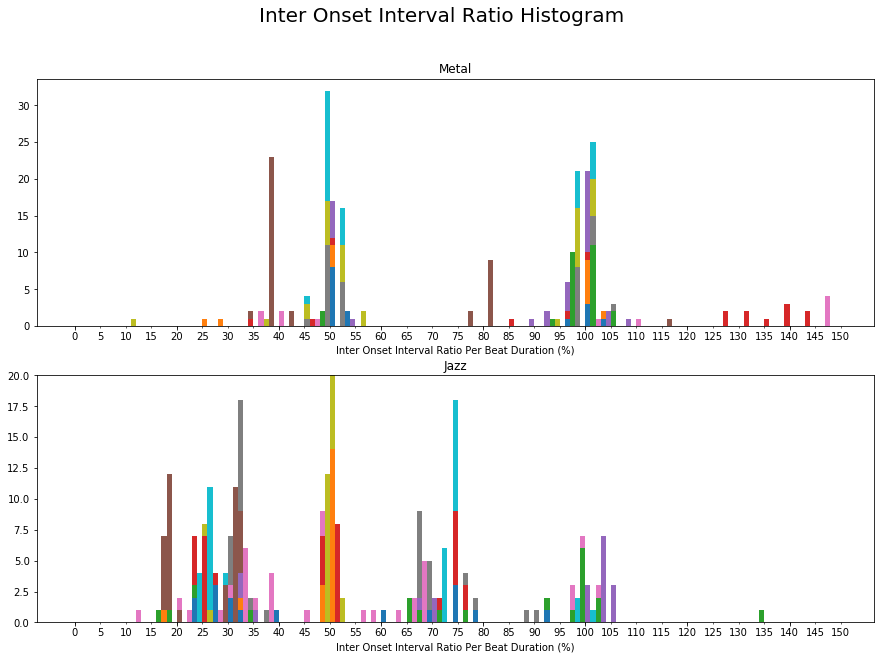

In [6]:
def createIIRatio (soundName):   
    onsets = MIRData[soundName]['onsets']
    bpm = MIRData[soundName]['bpm']
    bpmToSec = 60.0/float(bpm)
    interOnsetIntervals = onsets[1:] - onsets[:-1] #ii in short
    iiRatioPerCycle = list(map((lambda x: int(x/bpmToSec*100)), interOnsetIntervals))
    return iiRatioPerCycle

metalSoundName = ['metal'+str(x).zfill(2) for x in range(1, 11)]
jazzSoundName = ['jazz'+str(x).zfill(2) for x in range(1, 11)]
metalIIRatio = [createIIRatio(r) for r in metalSoundName]
jazzIIRatio = [createIIRatio(r) for r in jazzSoundName]

html = "<H2>Inter Onset Interval Ratio for Jazz and Metal Drum Loops</H2>"
html += "<p>"
html += ("It is noteworthy that IOI ratio for metal drum loops are centered around 50% and 100% indicating its duple nature, "
     "while jazz shows not only duple but also triple around 17%, 33%, and 66%. "
     "Metal beats are usually very fast, which is not detected well with HFC. "
     "You can use complex phase to see more subdivision in the metal loops although it tends to be noisy. ")
html += "</p>"

display(HTML(html))

# Beat Division Histograms
fig0, axs = plt.subplots(nrows=2, ncols=1)
fig0.suptitle('Inter Onset Interval Ratio Histogram', fontsize=20)

axs[0].hist(metalIIRatio, bins=range(150), histtype='bar', stacked=True)
axs[0].set_title('Metal')
axs[0].set_xlabel('Inter Onset Interval Ratio Per Beat Duration (%)')
axs[1].hist(jazzIIRatio, bins=range(150), histtype='bar', stacked=True)
axs[1].set_title('Jazz')
axs[1].set_xlabel('Inter Onset Interval Ratio Per Beat Duration (%)')

ticks = np.array([x for x in range(0,151,5)])
for ax in axs:
    ax.set_xticks(ticks, True)
    ax.set_xticklabels(labels=[], minor=False)
    ax.set_xticklabels(labels=ticks, minor=True)

fig0.set_size_inches(15, 10)

plt.show()

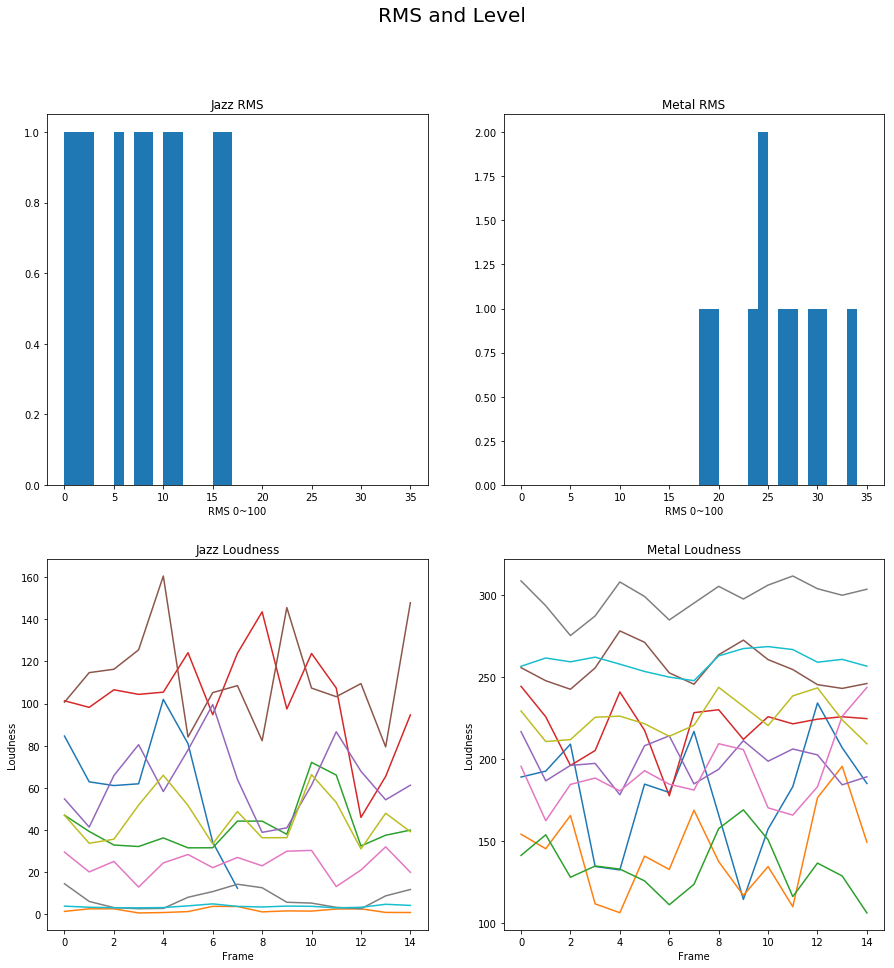

In [7]:
# RMS Histogram and Level Plot

html = "<H2>RMS and Level Difference bewteen Jazz and Metal</H2>"
html += "<p>"
html += ("RMS and level indicate loudness of drum loops. "
     "In real performance, drums wouldn't show huge difference provided they are the same kinds of drums. "
     "However, in mixing, it is very noticeable that jazz loops are significantly softer. "
     "Level is based on the Steven's Law, and does not have a clear unit. "
     "Level is extracted per frame, therefore it is shown in an array. ")
html += "</p>"

display(HTML(html))

fig1, axss = plt.subplots(nrows=2, ncols=2)
(jRMS, mRMS, jLevel, mLevel) = axss.flatten() 
fig1.suptitle('RMS and Level', fontsize=20)

#plot Jazz RMS
jr = [rms*100 for rms in [MIRData[soundName]['rms'] for soundName in jazzSoundName]]
jRMS.set_title('Jazz RMS')
jRMS.set_xlabel('RMS 0~100')
jRMS.hist(jr, bins=range(36))

#plot Metal RMS
mr = [rms*100 for rms in [MIRData[soundName]['rms'] for soundName in metalSoundName]]
mRMS.set_title('Metal RMS')
mRMS.set_xlabel('RMS 0~100')
mRMS.hist(mr, bins=range(36))

tabColor = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

#plot Jazz Level
jLevel.set_title('Jazz Loudness')
jLevel.set_xlabel('Frame')
jLevel.set_ylabel('Loudness')
for i, soundName in enumerate(jazzSoundName):
    jLevel.plot(MIRData[soundName]['level'], color=tabColor[i])

#plot Metal Level
mLevel.set_title('Metal Loudness')
mLevel.set_xlabel('Frame')
mLevel.set_ylabel('Loudness')
for i, soundName in enumerate(metalSoundName):
    mLevel.plot(MIRData[soundName]['level'], color=tabColor[i])

fig1.set_size_inches(15, 15)

plt.show()